In [27]:
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [28]:
import os
import re
import numpy as np
import pandas as pd
import multiprocessing
from tqdm.notebook import tqdm
import textwrap
import pickle
import torch
from accelerate import init_empty_weights, Accelerator
from transformers import AutoModelForCausalLM, AutoTokenizer
from src.custom_modeling_opt import CustomOPTForCausalLM
from matplotlib import pyplot as plt
import seaborn as sns
import moses

In [29]:
seed_value=42
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [30]:
import rdkit.Chem as Chem
import sys
from rdkit.Chem import RDConfig, MACCSkeys, QED
from rdkit.Chem.rdMolDescriptors import CalcTPSA, CalcCrippenDescriptors
from rdkit.Chem import Descriptors
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer

In [31]:
device = "cuda:1"

In [32]:
tokenizer = AutoTokenizer.from_pretrained("/home/menuab/code/ChemLacticaTestSuite/src/tokenizer/ChemLacticaTokenizer_50066/")
print('tokenizer size: ', len(tokenizer))

tokenizer size:  50066


In [33]:
checkpoint_path = "/home/menuab/code/checkpoints/f2c6ebb289994595a478f513/125m_126k_f2c6/"
checkpoint_path = "/home/menuab/code/checkpoints/f3fbd012918247a388efa732/125m_126k_f3fb/"
checkpoint_path

'/home/menuab/code/checkpoints/f3fbd012918247a388efa732/125m_126k_f3fb/'

In [34]:
model = CustomOPTForCausalLM.from_pretrained(
            checkpoint_path,
            use_flash_attn=True,
            torch_dtype=torch.bfloat16
            )
model.eval()
model.to(device)
print(f'model loaded with embedding size of : {model.model.decoder.embed_tokens.num_embeddings}')
assert(model.model.decoder.embed_tokens.num_embeddings == len(tokenizer))

model loaded with embedding size of : 50066


In [11]:
moses_df = pd.read_csv('./data/dataset_v1.csv')
moses_df.head()

,SMILES,SPLIT
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train
2,CC1C2CCC(C2)C1CN(CCO)C(=O)c1ccc(Cl)cc1,test
3,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train
4,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train


In [12]:
moses_df[['SAS', 'QED', 'CLOGP', 'WEIGHT']] = 0

In [19]:
moses_df.head()

,SMILES,SPLIT,SAS,QED,CLOGP,WEIGHT
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,3.812618,0.897,1.681,281.083
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train,2.936327,0.862,3.729,292.098
2,CC1C2CCC(C2)C1CN(CCO)C(=O)c1ccc(Cl)cc1,test,4.128087,0.902,3.457,321.150
3,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train,2.663795,0.701,2.297,336.088
4,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train,2.989161,0.646,-2.213,254.102


In [18]:
moses_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1936962 entries, 0 to 1936961
Data columns (total 6 columns):
 #   Column  Dtype  
---  ------  -----  
 0   SMILES  object 
 1   SPLIT   object 
 2   SAS     float64
 3   QED     float64
 4   CLOGP   float64
 5   WEIGHT  float64
dtypes: float64(4), object(2)
memory usage: 88.7+ MB


In [16]:
# Define the worker function
def process_molecule(mol):
    # print(mol)
    try:
        mol_source = Chem.MolFromSmiles(mol)
        sas_score = sascorer.calculateScore(mol_source) 
        qed_score = round(QED.qed(mol_source), 3)
        clogp_score = round(Descriptors.MolLogP(mol_source), 3)
        weight_score = round(Descriptors.ExactMolWt(mol_source), 3)
        return sas_score, qed_score, clogp_score, weight_score
    except:
        return None

# Main function to use multiprocessing
def process_many_molecules(df):
    # Create a pool of workers
    with multiprocessing.Pool(6) as pool:
        # Process the molecules using the pool
        results = list(tqdm(pool.imap(process_molecule, df.iloc[:,0]), total=len(df)))
    # print(len(results))

    # Store the results back into the DataFrame
    for en, (sas_score, qed_score, clogp_score, weight_score) in enumerate(results):
        df.iloc[en, 2] = sas_score
        df.iloc[en, 3] = qed_score
        df.iloc[en, 4] = clogp_score
        df.iloc[en, 5] = weight_score

In [17]:
process_many_molecules(moses_df)

  0%|          | 0/1936962 [00:00<?, ?it/s]

In [21]:
moses_df.head()

,SMILES,SPLIT,SAS,QED,CLOGP,WEIGHT
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,3.812618,0.897,1.681,281.083
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train,2.936327,0.862,3.729,292.098
2,CC1C2CCC(C2)C1CN(CCO)C(=O)c1ccc(Cl)cc1,test,4.128087,0.902,3.457,321.150
3,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train,2.663795,0.701,2.297,336.088
4,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train,2.989161,0.646,-2.213,254.102


In [23]:
moses_df.to_csv('moses_calculated.csv')

In [36]:
moses_df = pd.read_csv('../data/moses_calculated.csv', index_col=0)

In [37]:
moses_df = moses_df[moses_df.SPLIT == 'train']
moses_df.head()

,SMILES,SPLIT,SAS,QED,CLOGP,WEIGHT
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,3.812618,0.897,1.681,281.083
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train,2.936327,0.862,3.729,292.098
3,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train,2.663795,0.701,2.297,336.088
4,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train,2.989161,0.646,-2.213,254.102
5,CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,train,3.055750,0.853,0.807,271.061


In [38]:
moses_df.head(20)

,SMILES,SPLIT,SAS,QED,CLOGP,WEIGHT
0,CCCS(=O)c1ccc2[nH]c(=NC(=O)OC)[nH]c2c1,train,3.812618,0.897,1.681,281.083
1,CC(C)(C)C(=O)C(Oc1ccc(Cl)cc1)n1ccnc1,train,2.936327,0.862,3.729,292.098
3,Cc1c(Cl)cccc1Nc1ncccc1C(=O)OCC(O)CO,train,2.663795,0.701,2.297,336.088
4,Cn1cnc2c1c(=O)n(CC(O)CO)c(=O)n2C,train,2.989161,0.646,-2.213,254.102
5,CC1Oc2ccc(Cl)cc2N(CC(O)CO)C1=O,train,3.055750,0.853,0.807,271.061
7,CCOC(=O)c1cncn1C1CCCc2ccccc21,train,2.730231,0.805,2.986,270.137
9,COc1ccccc1OC(=O)Oc1ccccc1OC,train,1.676177,0.632,3.282,274.084
10,O=C1Nc2ccc(Cl)cc2C(c2ccccc2Cl)=NC1O,train,2.807838,0.848,3.101,320.012
11,CN1C(=O)C(O)N=C(c2ccccc2Cl)c2cc(Cl)ccc21,train,2.817707,0.871,3.126,334.028
12,CCC(=O)c1ccc(OCC(O)CO)c(OC)c1,train,2.393809,0.710,1.020,254.115


In [39]:
batch_size = 8
num_return_sequences = 6
# Initialize lists to store results
targets1, targets2, targets3, targets4 = [], [], [], []
sas_scores, clogp_scores, qed_scores, weight_scores = [], [], [], []
sac_invalids, mols = [], []

# Process in batches
for batch_start in tqdm(range(0, min(32000, len(moses_df)), batch_size)):
    batch_end = min(batch_start + batch_size, len(moses_df))
    inputs_batch = []

    for i in range(batch_start, batch_end):
        mol, split, sas, qed, clogp, weight = moses_df.iloc[i, :] # one more column in CSV
        prompt = f"</s>[SAS]{sas:.2f}[/SAS][CLOGP]{clogp:.2f}[/CLOGP][QED]{qed:.2f}[/QED][WEIGHT]{weight:.2f}[/WEIGHT]"
        inputs = tokenizer(prompt, return_tensors="pt").input_ids
        inputs = inputs.to(device)
        # print(inputs.shape, prompt)
        inputs_batch.append(inputs.squeeze(0))  # Remove the extra dimension

    min_length = min([len(i) for i in inputs_batch])

    inputs_batch = torch.stack([i[:min_length] for i in inputs_batch])  # Cutting the last tokens of long sequences
    # print(torch.stack(inputs_batch))
    # print(inputs_batch.shape)

    # Generate outputs for the entire batch
    out = model.generate(inputs_batch, max_new_tokens=600, do_sample=False,
                            #   top_p = 1.0, 
                            num_return_sequences=6,
                            num_beams=6, length_penalty=-9, renormalize_logits=True,
                            repetition_penalty=1., diversity_penalty=1., num_beam_groups=3, 
                            eos_token_id=20, return_dict_in_generate=True, output_scores=True)

    # Process outputs for each sequence in the batch
    # print(i, out.sequences.shape)
    for j in range(0,num_return_sequences*batch_size,num_return_sequences):
        # print(out_seq)
        for seq in out.sequences[j:j+num_return_sequences]:
            decoded = tokenizer.decode(seq)
            # print(i,j, decoded)
            try:
                if "[END_SMILES]" not in decoded:
                    # print(batch_end)
                    continue
                captured_text = decoded[decoded.find("[START_SMILES]")+len("[START_SMILES]"):decoded.find("[END_SMILES]")]
                mols.append(captured_text)
                # print(i)
                break
            except:
                continue
    del out

  0%|          | 0/4000 [00:00<?, ?it/s]

In [16]:
len(mols), len(moses_df)

(1221, 1584663)

In [88]:
del out

In [17]:
mols

['CC(C)(C)C1=NC(=CS1)C(=O)N[C@@H]2CCS(=O)(=O)C2',
 'CC1=NC(=CS1)C(CC2=CC=CC=C2Cl)NC',
 'CC(C)(C)OC(=O)C(=O)NC1=CC=C(C=C1)C(=O)CSC2=NC=CN2',
 'CC(C)C(C(=O)O)NC(=O)C(CO)N',
 'CC1=C(SC(=N1)C)C(C)NC(=O)C2COCCO2',
 'CCCC(CC(=O)O)CNC(=O)CC1=CC=CO1',
 'COC1=CC=C(C=C1)CC(=O)NCC2=CC=C(C=C2)Cl',
 'CC(C)C(C1=CC=CS1)NC(=O)C2=C(C=CC(=C2)Br)[N+](=O)[O-]',
 'C1CC(OC1)C(=O)NC2=CC(=C(C=C2)Cl)C(=O)Cl',
 'CC1=C(SC(=N1)N2CCOCC2)C(=O)NCC=C',
 'CC(C)(C)OC(=O)N[C@@H]1COC[C@H]1C2=CC=CC=C2O',
 'CC(C)(C)OC(=O)C(C(=O)O)N1C(=O)CCC1=O',
 'CC(C)(C)OC(=O)N1CCC(C1)C(C2=CC(=CC=C2)Cl)O',
 'COC1=CC=CC=C1CC(=O)NC2CCCCC2N',
 'C1COCCN1C2=NC(=CS2)C(C3=CC=CC=C3)O',
 'CC(C1=CC=CC=C1)NC(=O)CN2CCCC2CO',
 'CC1=CC=C(C=C1)S(=O)(=O)N2CCN(CC2)C(=O)N[C@H]3CCCC[C@@H]3O',
 'CC1=NC(=CS1)C(=O)C(=O)NC(C)C2=CC=C(C=C2)OC',
 'CC1=C(SC(=N1)N2CCS(=O)(=O)CC2)C(=O)O',
 'CC(C)(C)OC(=O)NCC1=NC(=NO1)C2=CC=C(C=C2)Cl',
 'CC(C1=CC=C(S1)Cl)NC(C)C2=CC=CC=C2OC',
 'C1=CC=C(C=C1)C2=CC=C(C=C2)C(=O)NCC(=O)NCCO',
 'CC(C)(C)OC(=O)N1CCC(CC1)C(=O)C(C2=NC=CS2)C(=

In [15]:
moses.get_all_metrics(mols)

/home/menuab/miniconda3/envs/chemlactica2/lib/python3.10/site-packages/molsets-1.0-py3.10.egg/moses/metrics/metrics.py:215: UserWarning: Can't compute unique@10000.gen contains only 1221 molecules
  warnings.warn(


{'valid': 1.0,
 'unique@1000': 0.877,
 'unique@10000': 0.8787878787878788,
 'FCD/Test': 11.284941596074844,
 'SNN/Test': 0.5768313590836857,
 'Frag/Test': 0.945032081414825,
 'Scaf/Test': 0.31623238473707327,
 'FCD/TestSF': 12.537035663074846,
 'SNN/TestSF': 0.5648384899950535,
 'Frag/TestSF': 0.9442286274460616,
 'Scaf/TestSF': 0.20815364719034302,
 'IntDiv': 0.8244088207818497,
 'IntDiv2': 0.8095319168508759,
 'Filters': 0.8632268632268633,
 'logP': 0.1845873328558798,
 'SA': 0.34954245042493937,
 'QED': 0.026010808284646518,
 'weight': 20.528029370924646,
 'Novelty': 0.9282385834109972}

In [37]:
moses.get_all_metrics(mols)

{'valid': 0.9998662386302836,
 'unique@1000': 0.783,
 'unique@10000': 0.552,
 'FCD/Test': 13.882057061443234,
 'SNN/Test': 0.5653544820583485,
 'Frag/Test': 0.9480488568889218,
 'Scaf/Test': 0.473331480694392,
 'FCD/TestSF': 15.455489537255332,
 'SNN/TestSF': 0.5307505784925061,
 'Frag/TestSF': 0.9460658591701949,
 'Scaf/TestSF': 0.047363100183491325,
 'IntDiv': 0.8143060552035002,
 'IntDiv2': 0.8019330718978799,
 'Filters': 0.8446488294314382,
 'logP': 0.3248056260369703,
 'SA': 0.3455246923603318,
 'QED': 0.032140541042697035,
 'weight': 5.831536426554537,
 'Novelty': 0.9673476514754671}

In [34]:
moses.get_all_metrics(mols)

/home/menuab/miniconda3/envs/chemlactica2/lib/python3.10/site-packages/molsets-1.0-py3.10.egg/moses/metrics/metrics.py:215: UserWarning: Can't compute unique@10000.gen contains only 1171 molecules
  warnings.warn(


{'valid': 1.0,
 'unique@1000': 0.783,
 'unique@10000': 0.7839453458582408,
 'FCD/Test': 15.620033308668056,
 'SNN/Test': 0.5738871668924337,
 'Frag/Test': 0.946246830557038,
 'Scaf/Test': 0.4778403800837303,
 'FCD/TestSF': 17.255643627159984,
 'SNN/TestSF': 0.540148828703557,
 'Frag/TestSF': 0.9455142901444874,
 'Scaf/TestSF': 0.044530836863557965,
 'IntDiv': 0.8087986263344386,
 'IntDiv2': 0.7932889954741383,
 'Filters': 0.8736122971818958,
 'logP': 0.2783546268880118,
 'SA': 0.40203663730200645,
 'QED': 0.028565578194885127,
 'weight': 12.01023532199757,
 'Novelty': 0.9259259259259259}

array([[<Axes: title={'center': 'SAS'}>, <Axes: title={'center': 'QED'}>],
       [<Axes: title={'center': 'CLOGP'}>,
        <Axes: title={'center': 'WEIGHT'}>]], dtype=object)

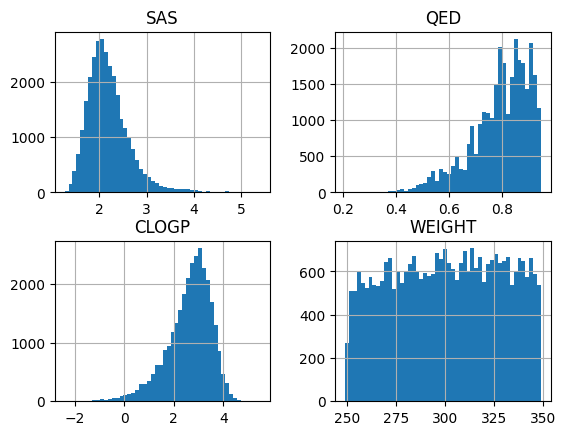

In [20]:
moses_df.iloc[:30000,:].hist(bins=50)

/home/menuab/miniconda3/envs/chemlactica2/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/home/menuab/miniconda3/envs/chemlactica2/lib/python3.10/site-packages/numpy/lib/histograms.py:885: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


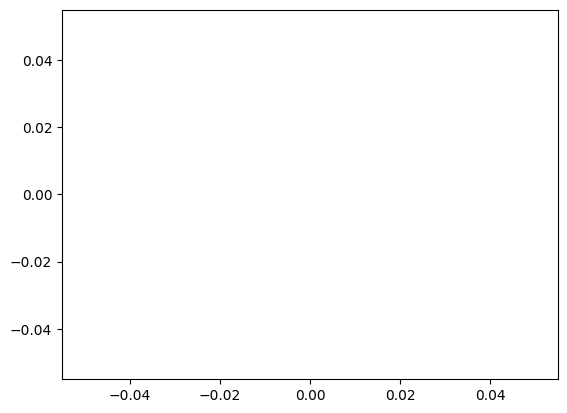

In [18]:
plt.hist(sas_scores, range=(0,8), bins=50, alpha=.5, density=True);
plt.hist(targets1, range=(0,8), bins=50, alpha=.5, density=True);

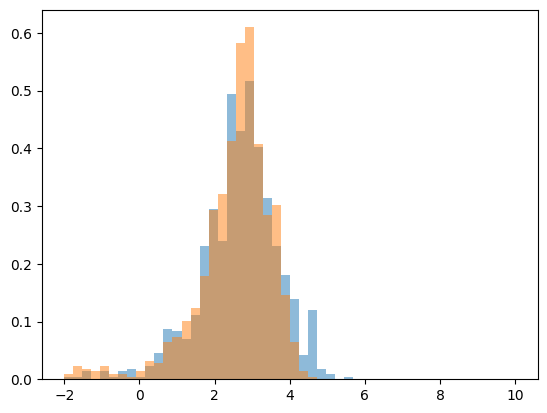

In [155]:
plt.hist(clogp_scores, range=(-2,10), bins=50, alpha=.5, density=True);
plt.hist(targets2, range=(-2,10), bins=50, alpha=.5, density=True);

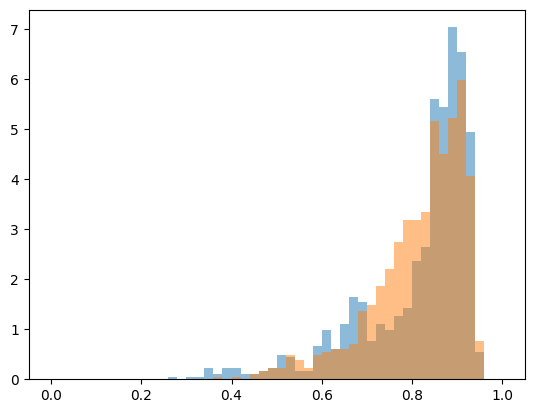

In [156]:
plt.hist(qed_scores, range=(0,1), bins=50, alpha=.5, density=True);
plt.hist(targets3, range=(0,1), bins=50, alpha=.5, density=True);

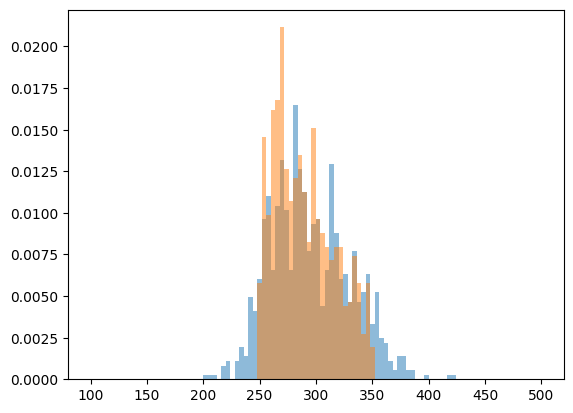

In [157]:
plt.hist(weight_scores, range=(100,500), bins=100, alpha=.5, density=True);
plt.hist(targets4, range=(100,500), bins=100, alpha=.5, density=True);

In [160]:
(np.array(targets4) < 250).sum()

0

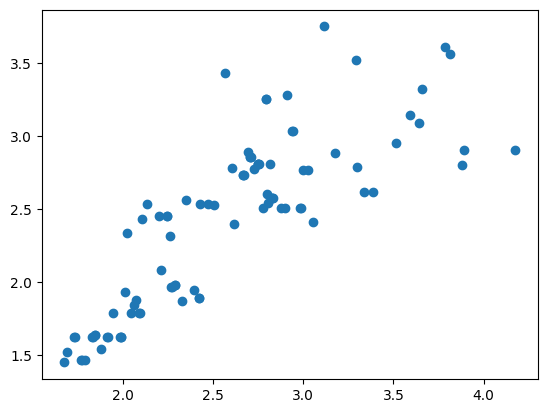

In [108]:
plt.scatter(sac_targets1, sac_scores)

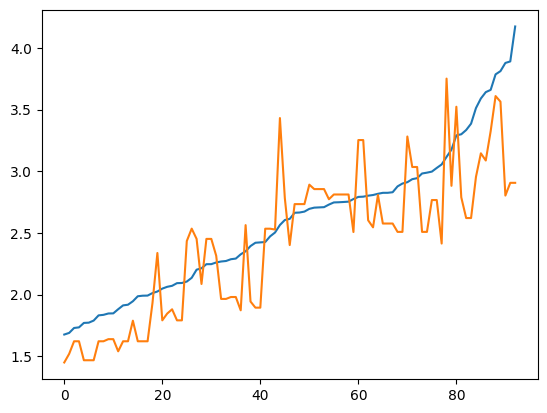

In [114]:
plt.plot(sorted(zip(sac_targets1, sac_scores)))

In [85]:
for _, sas, qed, clogp, weight in moses.iloc[1:10,[2,3,4,5]]:
          # mol, split, sas, qed, clogp, weight = sample
          print(sas, qed, clogp, weight)

ValueError: not enough values to unpack (expected 5, got 3)

In [100]:

for i in range(len(moses)):
          a,v=moses.iloc[i,3:5]
          print(a,v)
          break

0.897 1.681
